In [0]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2018-11-04 00:48:18--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt.1’

mini_classes.txt.1  100%[===================>]     760  --.-KB/s    in 0s      

2018-11-04 00:48:18 (55.7 MB/s) - ‘mini_classes.txt.1’ saved [760/760]



In [0]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [0]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28
print(len(x_train))

320000


In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
model = Sequential()
#Conv1层输入（28，28，1）输出（24，24，96）使用步长1来减少输出的宽和高，卷积核的数目比lenet大得多
model.add(Conv2D(96,(5,5),strides=(1,1),input_shape=x_train.shape[1:],padding='valid',activation='relu',kernel_initializer='uniform'))
#Pooling1层，输出（11，11，96）
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
#Conv2层，，输出（11，11，256）filter的数目为256，增加通道数目
model.add(BatchNormalization())#归一化层

model.add(Conv2D(256,(4,4),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
#Pooling2层，输出（5，5，256）
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

#连续三个卷积层，前两个卷积层不使用池化层减少宽和高，使用更小的卷积窗口，增加更多的卷积核数目，输出（5，5，384）
model.add(Conv2D(384,(3,3),padding='same',activation='relu',kernel_initializer='uniform'))
model.add(BatchNormalization())

model.add(Conv2D(384,(3,3),padding='same',activation='relu',kernel_initializer='uniform'))
model.add(BatchNormalization())

#输出（5，5，256）
model.add(Conv2D(256,(3,3),padding='same',activation='relu',kernel_initializer='uniform'))
#最后一个Pooling层，减少输出的宽和高（输出2，2，256）
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

#将多维输入一维化之后接FC
model.add(Flatten())
# 这里全连接层的输出个数比 LeNet 中的大数倍。使用丢弃层来缓解过拟合
model.add(Dense(4096,activation='relu'))
#Dropout将在训练过程中每次更新参数时按一定概率随机断开输入神经元
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))#使用丢弃层来缓解过拟合
model.add(BatchNormalization())

model.add(Dense(100,activation='softmax'))
adam = tf.train.AdamOptimizer() #随机梯度下降
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['top_k_categorical_accuracy'])
#categorical_crossentropy：多类对数损失
#optimizer优化器
#metrics：列表，包含评估模型在训练和测试时的性能的指标
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 96)        2496      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       393472    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 384)         885120    
__________

In [0]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=6)

Train on 288000 samples, validate on 32000 samples
Epoch 1/6
 - 152s - loss: 0.4791 - top_k_categorical_accuracy: 0.9684 - val_loss: 0.7274 - val_top_k_categorical_accuracy: 0.9469
Epoch 2/6
 - 152s - loss: 0.4225 - top_k_categorical_accuracy: 0.9729 - val_loss: 0.7551 - val_top_k_categorical_accuracy: 0.9459
Epoch 3/6
 - 152s - loss: 0.3796 - top_k_categorical_accuracy: 0.9770 - val_loss: 0.7486 - val_top_k_categorical_accuracy: 0.9484
Epoch 4/6
 - 152s - loss: 0.3291 - top_k_categorical_accuracy: 0.9810 - val_loss: 0.8018 - val_top_k_categorical_accuracy: 0.9465
Epoch 5/6


In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 94.82%


TensorFlow.js

['ice_cream', 'microphone', 'lightning', 'candle', 'pizza']


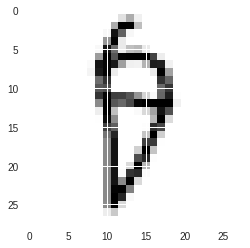

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))


In [0]:
!pip install tensorflowjs 

    100% |████████████████████████████████| 13.9MB 2.8MB/s 
    100% |████████████████████████████████| 63.0MB 638kB/s 
    100% |████████████████████████████████| 307kB 10.1MB/s 
    100% |████████████████████████████████| 573kB 15.3MB/s 
    100% |████████████████████████████████| 3.0MB 7.3MB/s 
keras 2.2.2 has requirement keras-applications==1.0.4, but you'll have keras-applications 1.0.6 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.5 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: setuptools 40.5.0
    Uninstalling setuptools-40.5.0:
      Successfully uninstalled setuptools-40.5.0
  Found existing installation: tensorboard 1.12.0
    Uninstalling tensorboard-1.12.0:
      Successfully uninstalled tensorboard-1.12.0
  Found existing installation: tensorflow 1.12.0rc2
    Uninstalling te

In [0]:
model.save('keras.h5')

/usr/local/lib/python3.6/dist-packages/keras/models.py:139: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  layer(computed_tensor, **kwargs))


In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

Using TensorFlow backend.


Zip and Download

In [0]:
!cp class_names.txt model/class_names.txt
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/group1-shard21of24 (deflated 7%)
  adding: model/group1-shard11of24 (deflated 7%)
  adding: model/group1-shard6of24 (deflated 7%)
  adding: model/group1-shard20of24 (deflated 7%)
  adding: model/group1-shard2of24 (deflated 7%)
  adding: model/group1-shard13of24 (deflated 7%)
  adding: model/group1-shard4of24 (deflated 7%)
  adding: model/group1-shard15of24 (deflated 7%)
  adding: model/group1-shard23of24 (deflated 7%)
  adding: model/group1-shard8of24 (deflated 7%)
  adding: model/group1-shard19of24 (deflated 7%)
  adding: model/group1-shard9of24 (deflated 7%)
  adding: model/class_names.txt (deflated 41%)
  adding: model/group1-shard17of24 (deflated 7%)
  adding: model/group1-shard3of24 (deflated 7%)
  adding: model/group1-shard22of24 (deflated 7%)
  adding: model/group1-shard1of24 (deflated 7%)
  adding: model/group1-shard18of24 (deflated 7%)
  adding: model/model.json (deflated 91%)
  adding: model/group1-shard7of24 (deflated 7%)
  adding

In [0]:
! ls

class_names.txt  keras.h5	   mini_classes.txt.1  model.zip
data		 mini_classes.txt  model	       sample_data


In [0]:
# from socket import error as SocketError
# import errno
# from google.colab import files
# try:
#   files.download('model.zip')
# except SocketError as e:
#   if e.errno != errno.ECONNRESET:
#     rase
#   pass
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model.zip'})
uploaded.SetContentFile('model.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Uploaded file with ID 1x5bszaiAyt2GPBZsLnm9LJT9h9rrs02w
